In [1]:
%matplotlib inline

import os
import tensorflow as tf
from tensorflow.keras import models, layers
import numpy as np
from cv2 import cv2 as cv
import pickle
from matplotlib import pyplot as plt
import random

print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [2]:
def create_img_class_dataset(img_dir, img_height, img_width, class_val):
    """Creates an image dataset for a class from a specified directory"""
    dataset = []
    i = 0
    for img_file in os.listdir(img_dir):
        img_path = os.path.join(img_dir, img_file)
        img = cv.imread(img_path)
        img = cv.resize(img, (img_height, img_width), interpolation=cv.INTER_AREA)
        img = np.array(img)
        img = img.astype('float32')
        img /= 255
        
        #img_entry = np.array([1, img])
        dataset.append([class_val, img])
    #dataset = np.array(dataset, dtype=np.ndarray)
    return dataset

In [3]:
IMG_HEIGHT = 128
IMG_WIDTH = 128

np.random.seed(42)
train_set = []
test_set = []

try:
    train_set = pickle.load(open("train_set.pickle", "rb"))
    test_set = pickle.load(open("test_set.pickle", "rb"))
    print("Datasets loaded from pickle files")
except:
    print("No pickle files found, compiling dataset variables")
    cat_set = create_img_class_dataset('kagglecatsanddogs_5340/PetImages/Cat', IMG_HEIGHT, IMG_WIDTH, 0)
    dog_set = create_img_class_dataset('kagglecatsanddogs_5340/PetImages/Dog', IMG_HEIGHT, IMG_WIDTH, 1)
    np.random.shuffle(cat_set)
    np.random.shuffle(dog_set)
    
    cat_train = cat_set[:int(len(cat_set)*0.7)]
    cat_test = cat_set[int(len(cat_set)*0.7):]
    
    dog_train = dog_set[:int(len(cat_set)*0.7)]
    dog_test = dog_set[int(len(cat_set)*0.7):]
    
    train_set = cat_train + dog_train
    test_set = cat_test + dog_test
    
    np.random.shuffle(train_set)
    np.random.shuffle(test_set)
    
    with open('train_set.pickle', 'wb') as handle:
        pickle.dump(train_set, handle, protocol=pickle.HIGHEST_PROTOCOL)
    
    with open('test_set.pickle', 'wb') as handle:
        pickle.dump(test_set, handle, protocol=pickle.HIGHEST_PROTOCOL)



Datasets loaded from pickle files


In [4]:
train_set_data = []
train_set_labels = []

for i in range(len(train_set)):
    train_set_labels.append(train_set[i][0])
    train_set_data.append(train_set[i][1])

train_set_labels = np.array(train_set_labels)
train_set_data = np.array(train_set_data)

In [5]:
test_set_data = []
test_set_labels = []

for i in range(len(test_set)):
    test_set_labels.append(test_set[i][0])
    test_set_data.append(test_set[i][1])

test_set_labels = np.array(test_set_labels)
test_set_data = np.array(test_set_data)

In [ ]:
print(train_set_data)
print(train_set_labels)

In [6]:
model = models.Sequential()
model.add(layers.Conv2D(128, (3, 3), activation='relu', input_shape=(IMG_HEIGHT, IMG_WIDTH, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(256, (3, 3), activation='relu'))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 126, 126, 128)     3584      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 63, 63, 128)      0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 61, 61, 128)       147584    
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 30, 30, 128)      0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 28, 28, 256)       295168    
                                                                 
Total params: 446,336
Trainable params: 446,336
Non-trai

In [7]:
model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 126, 126, 128)     3584      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 63, 63, 128)      0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 61, 61, 128)       147584    
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 30, 30, 128)      0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 28, 28, 256)       295168    
                                                                 
 flatten (Flatten)           (None, 200704)            0

In [8]:
model.compile(optimizer='adam', loss=tf.keras.losses.BinaryCrossentropy(), metrics=['accuracy'])

In [10]:
history = model.fit(train_set_data, train_set_labels, batch_size=32, epochs=12, validation_data=(test_set_data, test_set_labels))

InternalError: Failed copying input tensor from /job:localhost/replica:0/task:0/device:CPU:0 to /job:localhost/replica:0/task:0/device:GPU:0 in order to run _EagerConst: Dst tensor is not initialized.

1/1 [==============================] - 0s 12ms/step


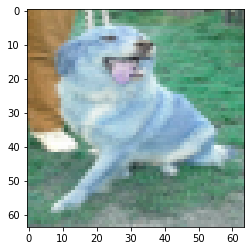

In [131]:
actual_labels = ['Cat', 'Dog']
rand_index = random.randint(0, len(test_set_data))
prediction_img = test_set_data[rand_index]
#prediction_img = cv.resize(prediction_img, (IMG_WIDTH, IMG_HEIGHT), interpolation=cv.INTER_AREA)
plt.imshow(prediction_img, interpolation='nearest')
prediction_img = prediction_img[None,:]
#print(prediction_img.shape)

#print(prediction_img.shape)
prediction = model.predict(prediction_img)



In [132]:
print("Prediction:", actual_labels[round(prediction[0][0])], "- Value:", prediction[0][0])

Prediction: Dog - Value: 0.9862053


In [133]:
print("Actual label:", actual_labels[test_set_labels[rand_index]])

Actual label: Dog


In [140]:
correct_preds = 0
for i in range(len(test_set_data)):
    prediction_img = test_set_data[i]
    prediction_img = prediction_img[None,:]
    prediction = model.predict(prediction_img)
    pred_val = actual_labels[round(prediction[0][0])]
    act_val = actual_labels[test_set_labels[i]]
    if pred_val == act_val:
        correct_preds += 1

pred_accuracy = correct_preds / len(test_set_data) * 100
print("Prediction accuracy =", pred_accuracy)

1/1 [==============================] - 0s 11ms/step
Prediction accuracy = 78.62973370801552


1/1 [==============================] - 0s 11ms/step
Prediction: Cat - Value: 0.4889423


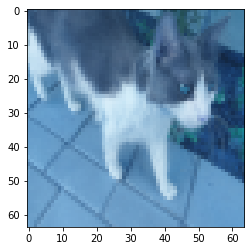

In [134]:
mishmish_img = cv.imread("mishmish2.jpg")
mishmish_img = cv.resize(mishmish_img, (IMG_WIDTH, IMG_HEIGHT), interpolation=cv.INTER_AREA)
mishmish_img = np.array(mishmish_img)
mishmish_img = mishmish_img.astype('float32')
mishmish_img /= 255
plt.imshow(mishmish_img, interpolation='nearest')
mishmish_img = mishmish_img[None,:]
mishmish_pred = model.predict(mishmish_img)
print("Prediction:", actual_labels[round(mishmish_pred[0][0])], "- Value:", mishmish_pred[0][0])